In [1]:
#   ScriptData

import pandas as pd
from alpha_vantage.timeseries import TimeSeries

class ScriptData:
    def __init__(self, api_key):
        self.api_key = api_key
        self.ts = TimeSeries(key=self.api_key, output_format='pandas')

    def fetch_intraday_data(self, symbol):
        data, _ = self.ts.get_intraday(symbol=symbol, interval='1min', outputsize='full')
        return data

    def convert_intraday_data(self, symbol):
        data = self.fetch_intraday_data(symbol)
        df = pd.DataFrame(data).rename(columns={'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. volume': 'volume'})
        df['timestamp'] = pd.to_datetime(df.index)
        df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
        return df.reset_index(drop=True)

api_key = "9ADF7OAQPCHJTGBR"  
data_obj = ScriptData(api_key)
symbol = "GOOGL"
data = data_obj.convert_intraday_data(symbol)
print(data.head())

            timestamp    open    high     low   close  volume
0 2023-06-13 19:59:00  123.81  123.83  123.81  123.81  1384.0
1 2023-06-13 19:56:00  123.84  123.85  123.79  123.80  1509.0
2 2023-06-13 19:55:00  123.83  123.84  123.80  123.84  2085.0
3 2023-06-13 19:54:00  123.84  123.84  123.84  123.84  1087.0
4 2023-06-13 19:53:00  123.84  123.84  123.83  123.83   873.0


In [7]:
type(data_obj)

__main__.ScriptData

In [8]:
# Fetching Intraday Stock Data using yfinance

import yfinance as yf
from datetime import datetime, timedelta

symbol = "GOOGL"
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=5)).strftime('%Y-%m-%d')

data = yf.download(symbol, start=start_date, end=end_date, interval="1m")


[*********************100%***********************]  1 of 1 completed


In [9]:
# Calculating Moving Average as an Indicator

def indicator1(df, timeperiod):
    indicator_df = pd.DataFrame()
    indicator_df['timestamp'] = df['timestamp']
    indicator_df['indicator'] = df['close'].rolling(window=timeperiod).mean()
    indicator_df = indicator_df.head(100)
    return indicator_df

df = data_obj.convert_intraday_data(symbol)
timeperiod = 5
result = indicator1(df, timeperiod)
print(result)


             timestamp  indicator
0  2023-06-13 19:59:00        NaN
1  2023-06-13 19:56:00        NaN
2  2023-06-13 19:55:00        NaN
3  2023-06-13 19:54:00        NaN
4  2023-06-13 19:53:00    123.824
..                 ...        ...
95 2023-06-13 16:43:00    123.670
96 2023-06-13 16:40:00    123.672
97 2023-06-13 16:39:00    123.654
98 2023-06-13 16:38:00    123.654
99 2023-06-13 16:37:00    123.640

[100 rows x 2 columns]


                          signal
Datetime                        
2023-06-14 09:34:00-04:00   SELL
2023-06-14 09:35:00-04:00   SELL
2023-06-14 09:36:00-04:00   SELL
2023-06-14 09:37:00-04:00    BUY
2023-06-14 09:38:00-04:00    BUY
...                          ...
2023-06-14 13:20:00-04:00   SELL
2023-06-14 13:21:00-04:00   SELL
2023-06-14 13:22:00-04:00   SELL
2023-06-14 13:23:00-04:00   SELL
2023-06-14 13:24:00-04:00   SELL

[231 rows x 1 columns]


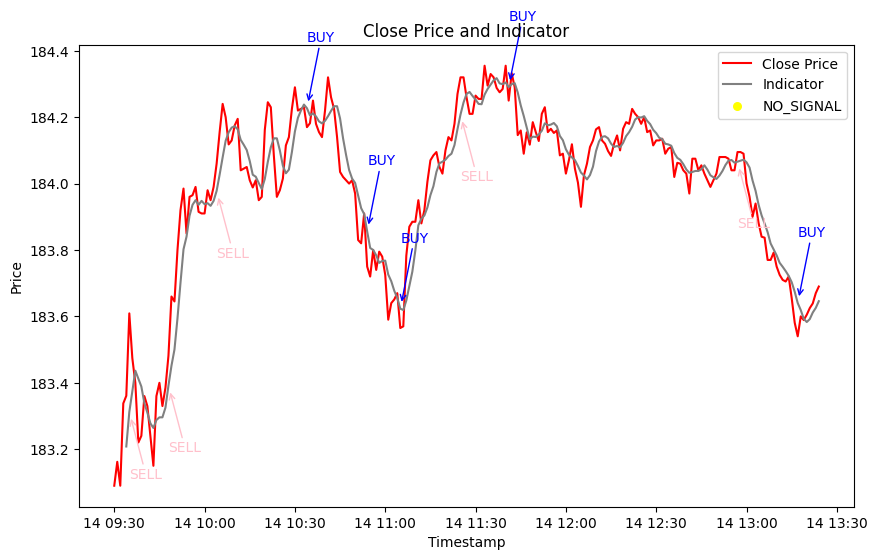

In [11]:
# Generating Signals and Visualizing Close Price with Indicator

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import random

class ScriptData:
    def __init__(self, api_key):
        self.api_key = api_key

    def fetch_intraday_data(self, symbol):
        data = yf.download(symbol, period='1d', interval='1m', progress=False)
        return data

    def convert_intraday_data(self, symbol):
        data = self.fetch_intraday_data(symbol)
        df = pd.DataFrame(data).rename(columns={'Close': 'close', 'Volume': 'volume'})
        df['timestamp'] = df.index
        df = df[['timestamp', 'close', 'volume']]
        return df

class Strategy:
    def __init__(self, api_key):
        self.api_key = api_key
        self.data_obj = ScriptData(self.api_key)

    def indicator1(self, df, timeperiod):
        indicator_df = pd.DataFrame()
        indicator_df['timestamp'] = df['timestamp']
        indicator_df['indicator'] = df['close'].rolling(window=timeperiod).mean()
        indicator_df = indicator_df.dropna()  
        return indicator_df

    def generate_signals(self, symbol, timeperiod):
        df = self.data_obj.convert_intraday_data(symbol)
        close_data = df['close']
        indicator_data = self.indicator1(df, timeperiod)['indicator']

        
        indicator_data_aligned = indicator_data.dropna()
        close_data_aligned = close_data.iloc[-len(indicator_data_aligned):]

       
        signals = pd.DataFrame(index=close_data_aligned.index)
        signals['signal'] = 'NO_SIGNAL'
        signals.loc[indicator_data_aligned > close_data_aligned, 'signal'] = 'BUY'
        signals.loc[indicator_data_aligned < close_data_aligned, 'signal'] = 'SELL'

        return signals, close_data, indicator_data
    
# Define ScriptData and Strategy classes
api_key = "9ADF7OAQPCHJTGBR"
symbol = "AAPL"
timeperiod = 5

# Create an instance of the Strategy class
strategy = Strategy(api_key)
signals, close_data, indicator_data = strategy.generate_signals(symbol, timeperiod)

# Filter the signals for 'BUY' and 'SELL' only
filtered_signals = signals[signals['signal'].isin(['BUY', 'SELL'])]
print(filtered_signals)


# Plot close price and indicator
plt.figure(figsize=(10, 6))
plt.plot(close_data.index, close_data, color='red', label='Close Price')
plt.plot(indicator_data.index, indicator_data, color='grey', label='Indicator')

# Annotate buy signals
buy_signals = filtered_signals[filtered_signals['signal'] == 'BUY'].index.tolist()
random.shuffle(buy_signals)
for buy_signal in buy_signals[:5]:  
    plt.annotate('BUY', xy=(buy_signal, indicator_data.loc[buy_signal]), xytext=(buy_signal, indicator_data.loc[buy_signal] + 0.2),
                 arrowprops=dict(facecolor='blue', edgecolor='blue', arrowstyle='->', shrinkA=0.5, shrinkB=5), color='blue')

# Annotate sell signals
sell_signals = filtered_signals[filtered_signals['signal'] == 'SELL'].index.tolist()
random.shuffle(sell_signals)
for sell_signal in sell_signals[:5]:  
    plt.annotate('SELL', xy=(sell_signal, indicator_data.loc[sell_signal]), xytext=(sell_signal, indicator_data.loc[sell_signal] - 0.2),
                 arrowprops=dict(facecolor='pink', edgecolor='pink', arrowstyle='->', shrinkA=0.5, shrinkB=5), color='pink')

# Scatter plot for 'NO_SIGNAL' points
no_signal_indices = signals[signals['signal'] == 'NO_SIGNAL'].sample(n=min(5, len(signals[signals['signal'] == 'NO_SIGNAL'])), random_state=42).index
plt.scatter(no_signal_indices, indicator_data.loc[no_signal_indices], c='yellow', marker='o', s=30, label='NO_SIGNAL')

# Plot formatting and display
plt.legend()
plt.title('Close Price and Indicator')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.show()
